# Stack Overflow Developer Survey 2022

A Stack Overflow Developer Survey é uma pesquisa anual realizada pela plataforma Stack Overflow, que coleta informações sobre a comunidade de desenvolvedores. A pesquisa abrange uma variedade de tópicos, como linguagens de programação, ferramentas, práticas de desenvolvimento e satisfação profissional. Os resultados são analisados e publicados em um relatório que fornece insights sobre tendências e percepções dos desenvolvedores. A pesquisa é uma fonte importante de informações para profissionais de tecnologia e empresas de desenvolvimento de software.

Com esse projeto, pretendemos analisar os dados da pesquisa de 2022 a fim de construir e comparar regressores para a predição de salários de desenvolvedores de software. Para isso, utilizaremos técnicas de aprendizado de máquina e estatística.

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [46]:
# load raw data
# remember to download the data from
# https://www.kaggle.com/datasets/dheemanthbhat/stack-overflow-annual-developer-survey-2022
# https://insights.stackoverflow.com/survey

raw = pd.read_csv('raw/survey_results_public.csv')

# select columns of interest

target_col = 'ConvertedCompYearly'
features_cols = ['Employment', 'RemoteWork', 'EdLevel', 'YearsCode', 'YearsCodePro', 'Country', 'Age', 'Gender']

# drop rows with missing data

raw = raw[raw[target_col].notnull()]
raw = raw[raw[features_cols].notnull().all(axis=1)]

raw = raw[raw['Age'] != 'Prefer not to say']
#
# does not drop 'Prefer not to say' in 'Gender', 'Trans', 'Sexuality', 'Ethnicity', 'Accessibility'
# as their absence may not be a missing value
#

#
# pode ser que isso seja um erro e inclusive diminuir ou comprimir o número de features pode ajudar a melhorar a precisão do modelo (não que eu esteja disposto a testar isso agora)
#
##
#
# atualização: foi um erro, removendo features tumultuando o modelo; colunas descartadas ['Trans', 'Sexuality', 'Ethnicity', 'Accessibility']
#

raw = raw.drop(raw.columns.difference(features_cols + [target_col]), axis=1)

# fix heterogeneous columns

raw['YearsCode'] = raw['YearsCode'].replace('Less than 1 year', 0)
raw['YearsCode'] = raw['YearsCode'].replace('More than 50 years', 51)

raw['YearsCodePro'] = raw['YearsCodePro'].replace('Less than 1 year', 0)
raw['YearsCodePro'] = raw['YearsCodePro'].replace('More than 50 years', 51)

# cast column to numeric

raw['YearsCode'] = raw['YearsCode'].astype('int64')
raw['YearsCodePro'] = raw['YearsCodePro'].astype('int64')

# split multi label columns (MultiHotEncoding)

raw = raw.drop('Employment', axis=1).join(raw['Employment'].str.get_dummies(sep=';').add_prefix('Empl_'))
raw = raw.drop('Gender', axis=1).join(raw['Gender'].str.get_dummies(sep=';').add_prefix('Gender_'))
#raw = raw.drop('Sexuality', axis=1).join(raw['Sexuality'].str.get_dummies(sep=';').add_prefix('Sexuality_'))
#raw = raw.drop('Ethnicity', axis=1).join(raw['Ethnicity'].str.get_dummies(sep=';').add_prefix('Ethnicity_'))
#raw = raw.drop('Accessibility', axis=1).join(raw['Accessibility'].str.get_dummies(sep=';').add_prefix('Accessibility_'))

# merge useless categories

raw['Gender_OTHER'] = raw['Gender_Non-binary, genderqueer, or gender non-conforming'] | raw['Gender_Or, in your own words:'] | raw['Gender_Prefer not to say']
raw.drop(columns=['Gender_Non-binary, genderqueer, or gender non-conforming', 'Gender_Or, in your own words:', 'Gender_Prefer not to say'], inplace=True)

raw['Country'] = raw['Country'].replace(raw['Country'].value_counts()[raw['Country'].value_counts() < 1000].index, 'OTHER')

# drop useless columns

raw.drop(columns=['Empl_Retired'], inplace=True)

# Select columns of interest

X_raw = raw.drop(target_col, axis=1)
y_raw = raw[target_col]

print('Total features in the dataset ', X_raw.shape)
raw

Total features in the dataset  (37627, 12)


,RemoteWork,EdLevel,YearsCode,YearsCodePro,Country,Age,ConvertedCompYearly,"Empl_Employed, full-time","Empl_Employed, part-time","Empl_Independent contractor, freelancer, or self-employed",Gender_Man,Gender_Woman,Gender_OTHER
2,"Hybrid (some remote, some in-person)","Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",14,5,United Kingdom of Great Britain and Northern I...,25-34 years old,40205.0,1,0,0,1,0,0
3,Fully remote,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",20,17,OTHER,35-44 years old,215232.0,1,0,0,1,0,0
8,"Hybrid (some remote, some in-person)","Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",6,6,OTHER,25-34 years old,49056.0,1,0,0,0,1,0
10,"Hybrid (some remote, some in-person)","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",5,2,United Kingdom of Great Britain and Northern I...,18-24 years old,60307.0,1,0,0,1,0,0
11,Fully remote,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",12,10,United States of America,35-44 years old,194400.0,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
73114,"Hybrid (some remote, some in-person)","Associate degree (A.A., A.S., etc.)",7,2,Germany,18-24 years old,41058.0,1,0,1,1,0,0
73116,"Hybrid (some remote, some in-person)","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",21,16,United States of America,35-44 years old,115000.0,1,0,0,1,0,0
73118,Fully remote,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",4,3,OTHER,25-34 years old,57720.0,1,0,0,1,0,0
73119,"Hybrid (some remote, some in-person)","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",5,1,United States of America,25-34 years old,70000.0,1,0,0,1,0,0


In [47]:
from sklearn.model_selection import train_test_split

# Split the data into train, validation, and test sets with proportions 70:10:20
X_train, X_val_test, y_train, y_val_test = train_test_split(
    X_raw,
    y_raw,
    test_size=0.3,
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_val_test,
    y_val_test,
    test_size=0.67,
    random_state=42
)

# check the shapes of the resulting train, validation, and test sets
# X and y have the same shape

print('Train set: ', X_train.shape[0])
print('Validation set: ', X_val.shape[0])
print('Test set: ', X_test.shape[0])

Train set:  26338
Validation set:  3725
Test set:  7564


In [51]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

# preprocess categorical data

one_hot_cols = ['Country', 'RemoteWork']
ordinal_cols = ['EdLevel', 'Age']

one_hot_transformer = Pipeline([
    ('onehot', OneHotEncoder())
])

ordinal_transformer = Pipeline([
    ('ordinal', OrdinalEncoder())
])

continuous_cols = X_raw.drop(columns=one_hot_cols + ordinal_cols).columns.tolist()
continuous_transformer = Pipeline([
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    [('one_hot', one_hot_transformer, one_hot_cols),
     ('ordinal', ordinal_transformer, ordinal_cols),
     ('continuous', continuous_transformer, continuous_cols)],
    remainder='passthrough')

X_train_preprocessed = preprocessor.fit_transform(X_train, y_raw)
X_val_preprocessed = preprocessor.transform(X_val)
X_test_preprocessed = preprocessor.transform(X_test)

X_preprocessed = preprocessor.transform(X_raw)

display(preprocessor.get_feature_names_out().shape)
display(preprocessor.get_feature_names_out())

(21,)

array(['one_hot__Country_Brazil', 'one_hot__Country_Canada',
       'one_hot__Country_France', 'one_hot__Country_Germany',
       'one_hot__Country_India', 'one_hot__Country_OTHER',
       'one_hot__Country_United Kingdom of Great Britain and Northern Ireland',
       'one_hot__Country_United States of America',
       'one_hot__RemoteWork_Full in-person',
       'one_hot__RemoteWork_Fully remote',
       'one_hot__RemoteWork_Hybrid (some remote, some in-person)',
       'ordinal__EdLevel', 'ordinal__Age', 'continuous__YearsCode',
       'continuous__YearsCodePro', 'continuous__Empl_Employed, full-time',
       'continuous__Empl_Employed, part-time',
       'continuous__Empl_Independent contractor, freelancer, or self-employed',
       'continuous__Gender_Man', 'continuous__Gender_Woman',
       'continuous__Gender_OTHER'], dtype=object)

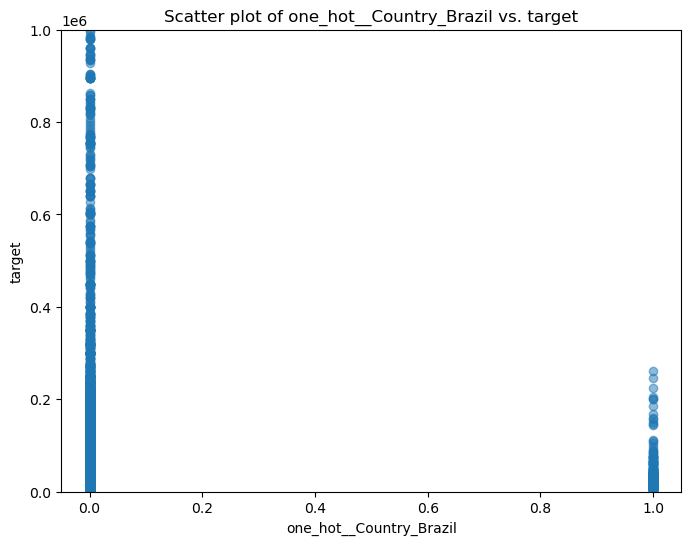

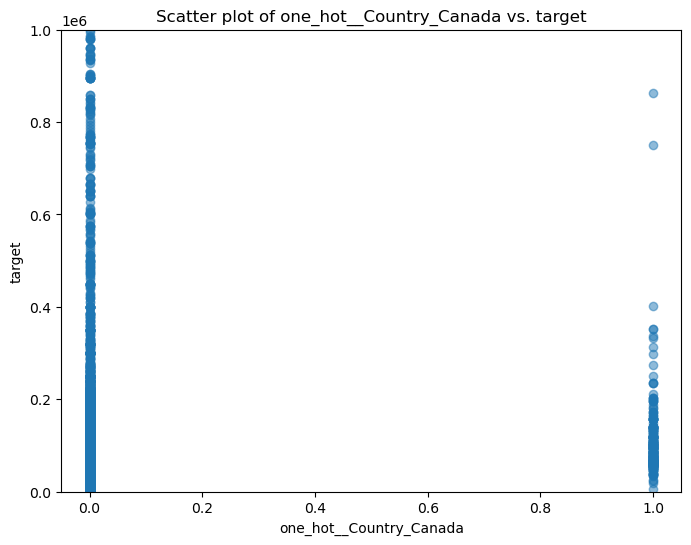

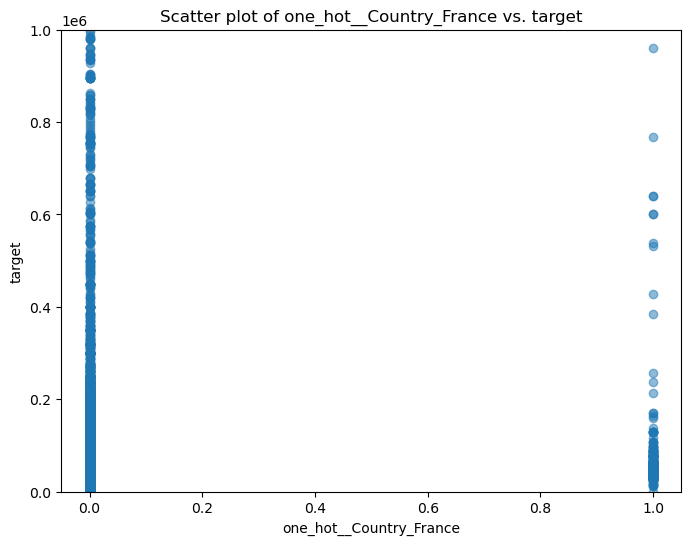

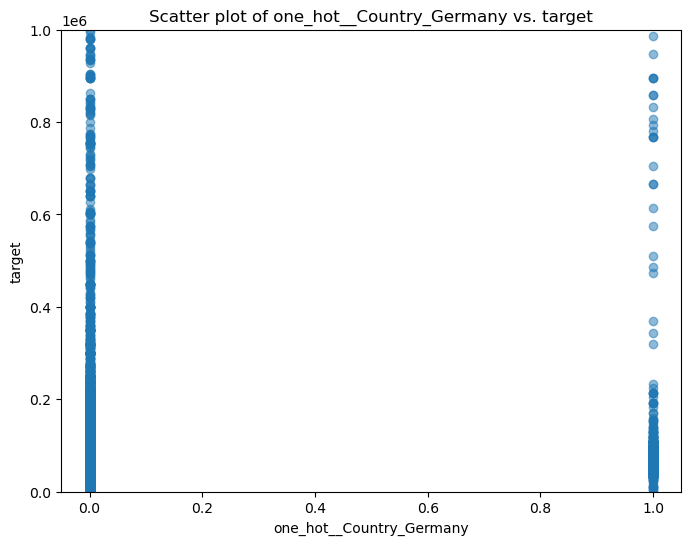

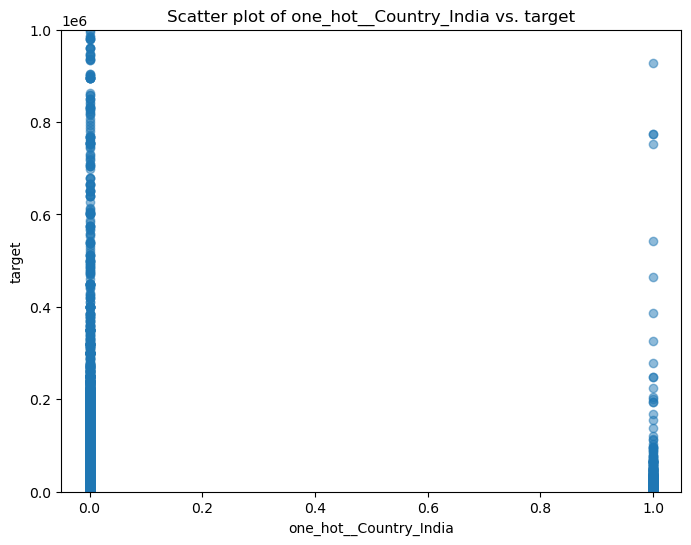

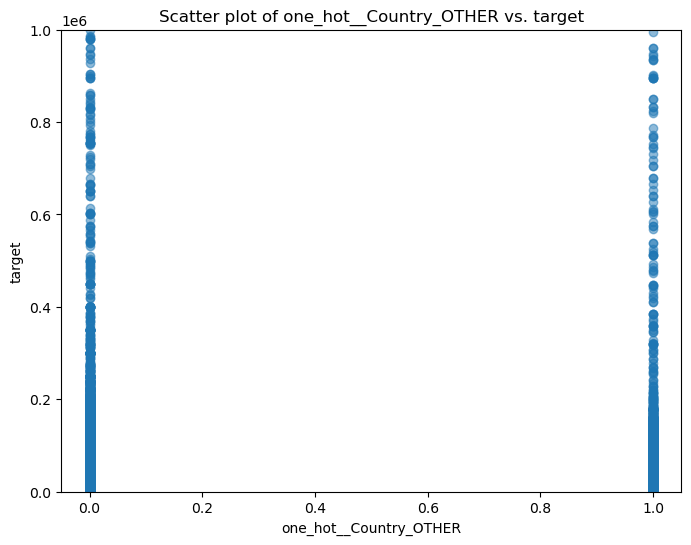

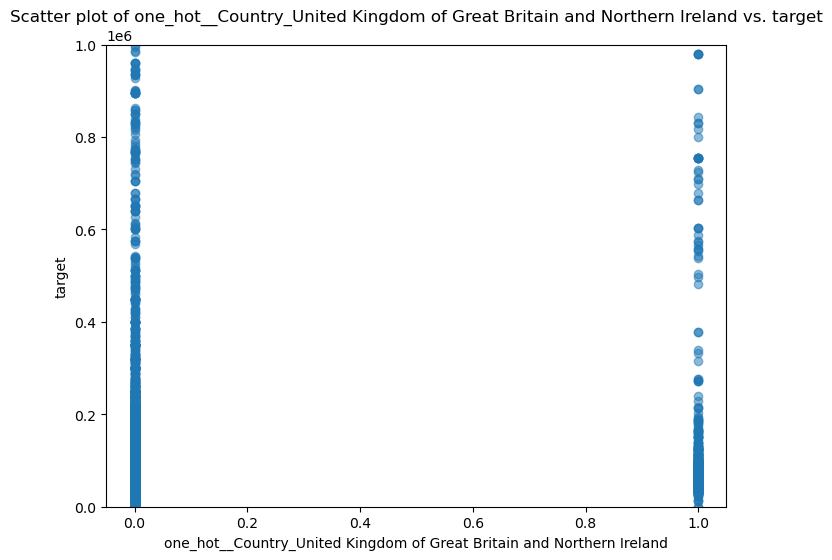

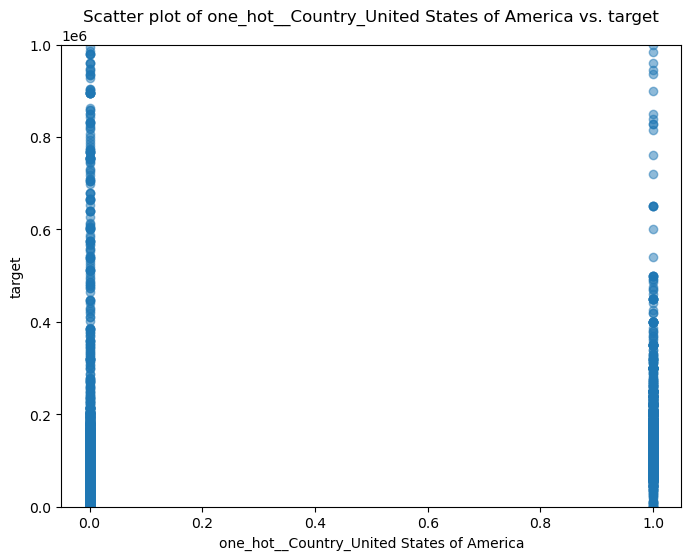

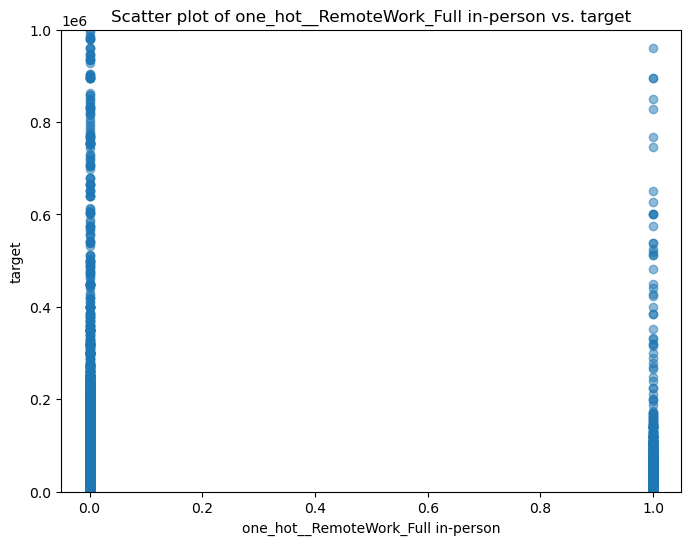

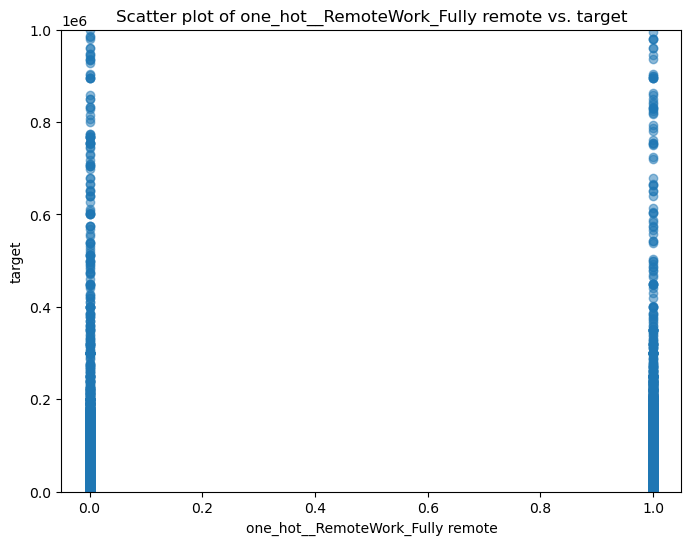

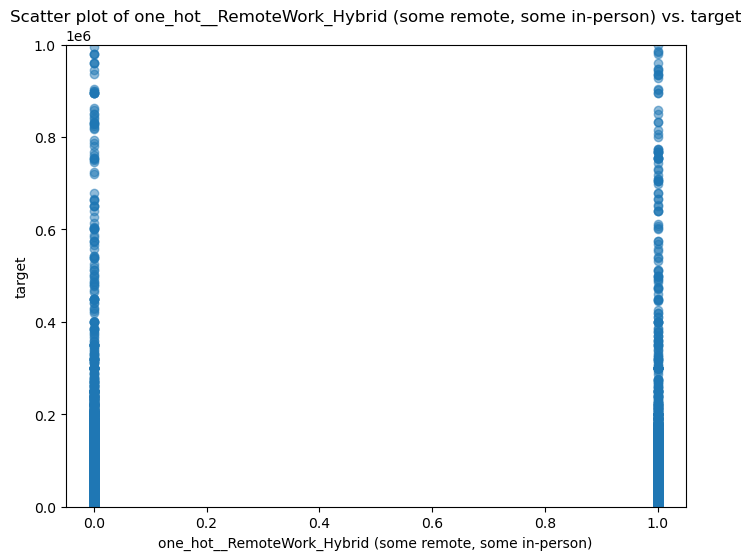

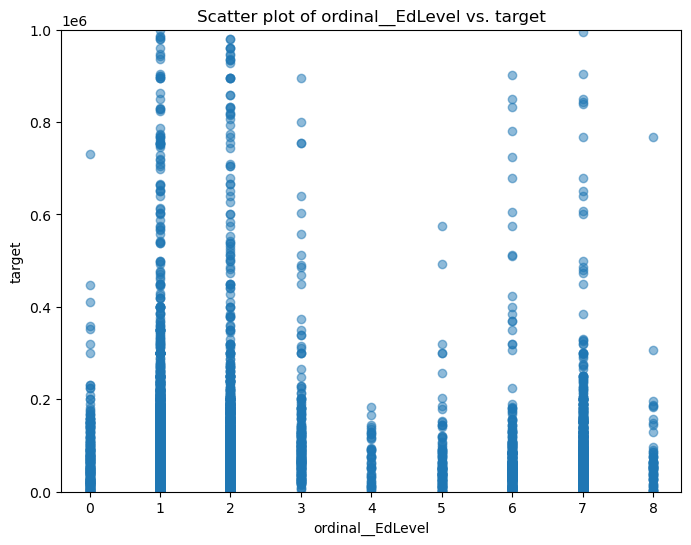

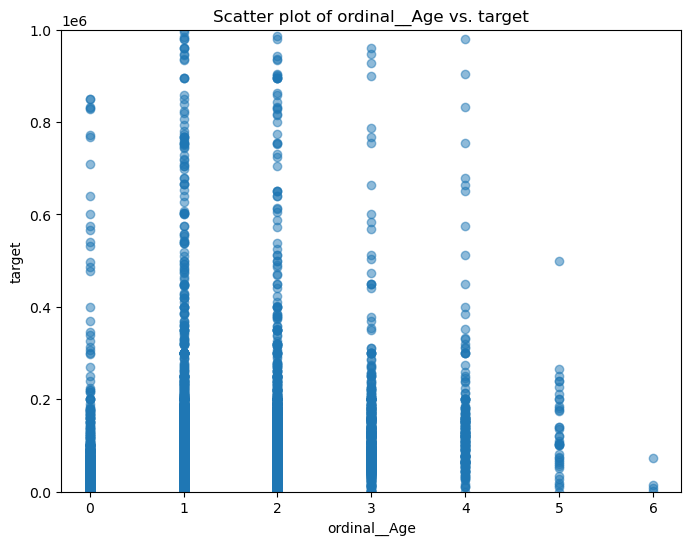

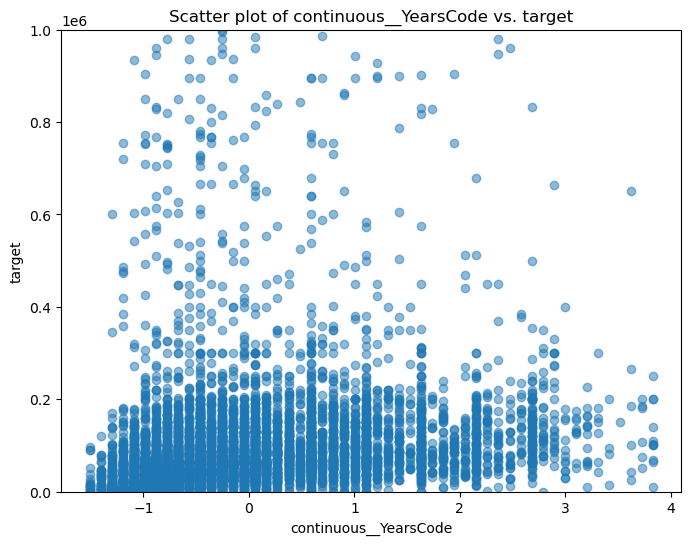

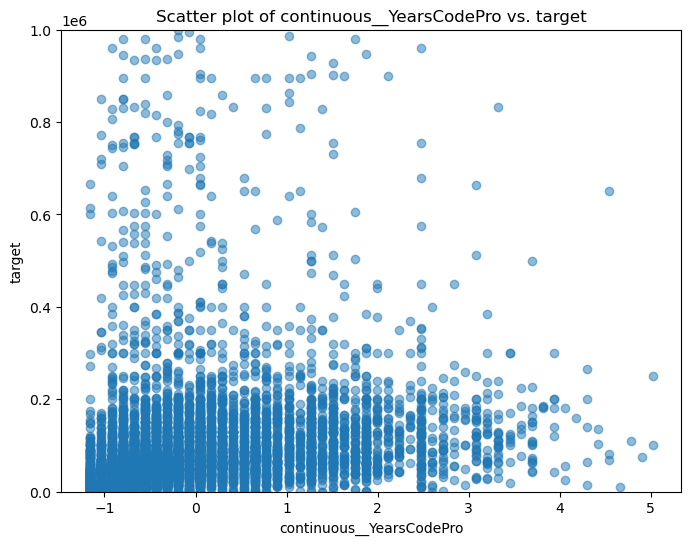

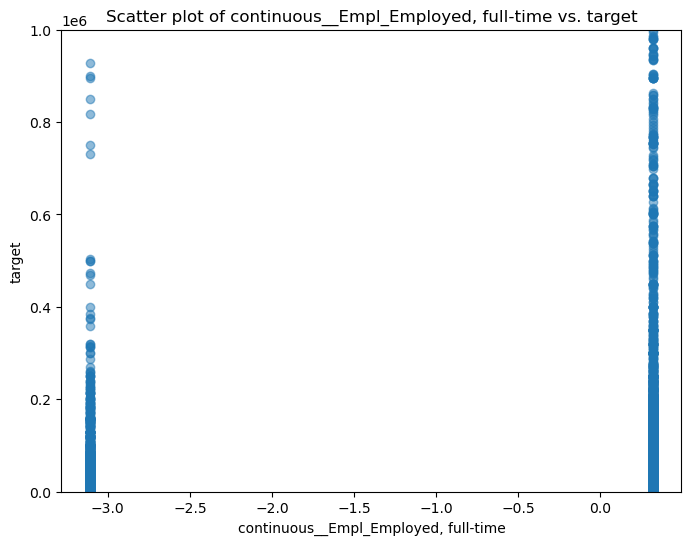

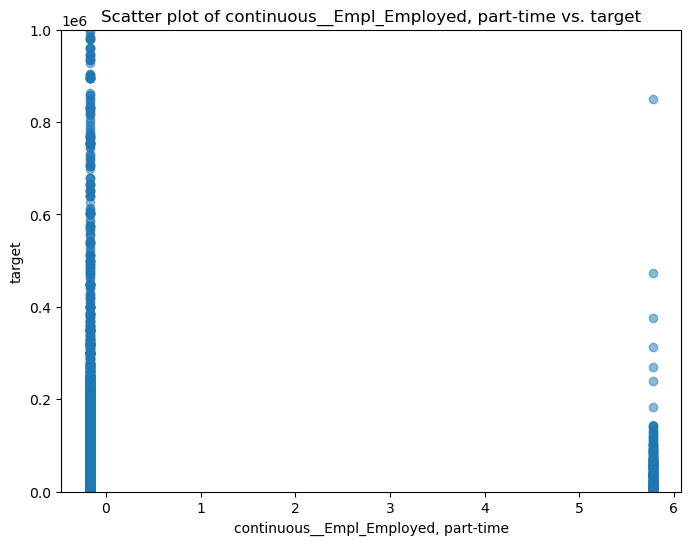

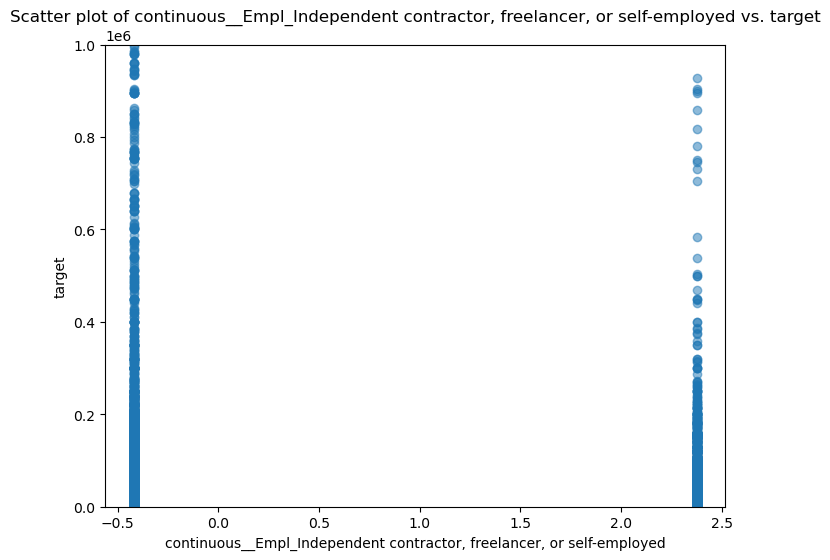

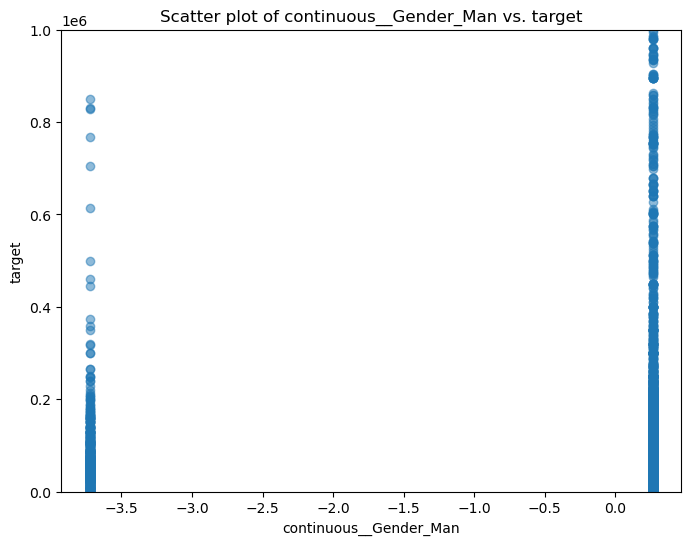

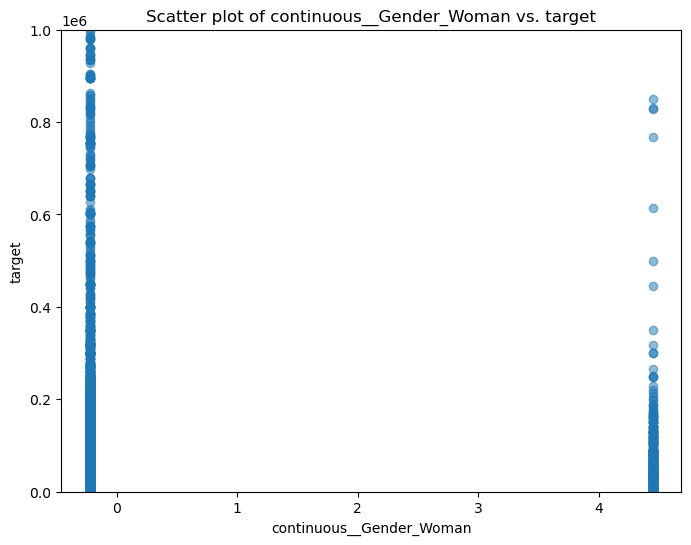

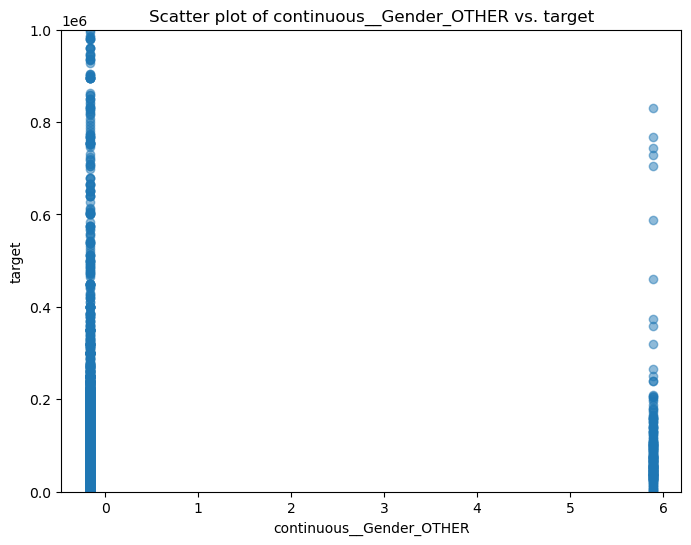

In [69]:
for i, feature_name in enumerate(preprocessor.get_feature_names_out()):
    plt.figure(figsize=(8, 6))
    plt.scatter(X_test_preprocessed[:, i], y_test, alpha=0.5)
    plt.xlabel(feature_name)
    plt.ylabel('target')
    plt.title(f'Scatter plot of {feature_name} vs. target')
    plt.ylim(top=1e6) #ymax is your value
    plt.ylim(bottom=0) #ymin is your value
    plt.show()

In [49]:
# stolen code didn't check

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

linear_regressor = LinearRegression()  # Create an instance of the regressor
linear_regressor.fit(X_train_preprocessed, y_train)  # Train the model

y_pred = linear_regressor.predict(X_test_preprocessed)  # Make predictions on the test set

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Mean Squared Error:', mse)
print('Mean Absolute Error:', mae)
print('R-squared:', r2)

Mean Squared Error: 450020732461.0879
Mean Absolute Error: 171806.21972501322
R-squared: 0.033012870118311
